<a id='top'></a>
# Detecting optic abnormalities through <br>Fundus photography
> *First level screening tool to reduce man-hours spent on grading retinal images* <br>
> An image classification model with binary outcomes



## Problem Statement

Accordingly, eye disease in Singapore is becoming extremely prevalent due to certain lifestyle factors and its rapidly ageing population. All eye conditions are projected to increase by 2040. While eye conditions such as myopia and refractive error would remain to be most prevalent in Singapore, other eye disease such as diabetic retinopathy (DR), cataract and glaucoma would see almost and over 100% increase each in the number of cases in the Country. With an inevitable increase in demand, healthcare providers are looking into development and provision of infrastructure and resources to adequately meet the eye care needs of the population.

The increase in prevalence comes with the need to detect and diagnose eye conditions in order to provide proper treatment and care. A technique used to detects eye conditions is known as Fundus Photography, a process whereby the the back of your eyes (retina) is photographed directly as the pupil is used as both an entrance and exit for the fundus camera's illuminating and imaging light rays. Ophthalmologists use these retinal photographs to follow, diagnose, and treat eye diseases.

Currently, fundus images are analysed by trained readers, which is described as a tedious, tiring and time-consuming process. The images currently go through up to three levels of checks. Primary graders are the first to take a look at an image and around half of all images at this level typically turn out to have no abnormalities. Images with abnormalities, as well as 10 per cent of the "normal" images, are then sent to a group of secondary graders. If the primary and secondary graders disagree in their analysis of an image, it will be sent to an ophthalmologist. Only about 5 per cent of such images reach this stage.

As part of preliminary efforts to reduce the intensive manpower required in the process, a Convolutional Neural Network model will be trained to classify if abnormalities are detected in the retinal images (i.e. binary outcome of 0:Normal or 1:Abnormal).

Metrics used to evaluate the model will be based on Accuracy, and Recall for the medical industry since its better to err on the side of caution, rather than missing out on a diagnosis which result in late treatment or other serious consequences.

## Dataset
Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients who have taken ocular health examination with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions. Patient identifying information will be removed. Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

Normal (N),
Diabetes (D),
Glaucoma (G),
Cataract (C),
Age related Macular Degeneration (A),
Hypertension (H),
Pathological Myopia (M),
Other diseases/abnormalities (O)

## 01 Data Cleaning & Exploratory Data Analysis

### Contents
- [Setup](#setup)
    - [Library imports](#lib_imports)
    - [Data imports](#data_imports)
- [Image metadata](#img_metadata)
    - [Preparing data](#prep_data)
    - [Labelling Abnormal or Normal](#label)
- [Images](#img_data)
    - [Creating image filepath](#img_filepath)
    - [Image properties](#img_prop)

<a id='setup'></a>
### Setup
<a id='lib_imports'></a>
#### Library imports

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import time
from tqdm import tqdm

#my_functions module
import my_functions as myfunc
import importlib
importlib.reload(myfunc)

%matplotlib inline

<a id='data_imports'></a>
#### Data imports

In [4]:
data = pd.read_csv('../assets/data.csv')
#preview data
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


<a id='img_metadata'></a>
### Image Metadata

In [5]:
data.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O'],
      dtype='object')

In [6]:
#call function to print information
myfunc.basic_eda(data, "Fundus Imaging")

DATAFRAME INFORMATION
---------------------------------------
Rows: 3500             Columns: 15
Duplicated rows: 0
Columns:
                          data_type  num_nulls  num_not_nulls  unique_values
ID                            int64          0           3500           3500
Patient Age                   int64          0           3500             75
Patient Sex                  object          0           3500              2
Left-Fundus                  object          0           3500           3500
Right-Fundus                 object          0           3500           3500
Left-Diagnostic Keywords     object          0           3500            227
Right-Diagnostic Keywords    object          0           3500            233
N                             int64          0           3500              2
D                             int64          0           3500              2
G                             int64          0           3500              2
C                           

<a id='prep_data'></a>
#### Preparing Data
Split left and right fundus images into different lines

In [7]:
feat_l = ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Left-Diagnostic Keywords']
feat_r = ['ID', 'Patient Age', 'Patient Sex', 'Right-Fundus', 'Right-Diagnostic Keywords']

# {'Left-Fundus': 'Left-Fundus', 'Left-Diagnostic Keywords': 'Diagnostic Keywords'}
data_l = data[feat_l].rename(columns= {'Left-Fundus': 'Fundus',
                                       'Left-Diagnostic Keywords': 'Diagnostic Keywords'})
#Denote which eye
data_l['oculus'] = "L"
data_r = data[feat_r].rename(columns= {'Right-Fundus': 'Fundus',
                                       'Right-Diagnostic Keywords': 'Diagnostic Keywords'})
data_r['oculus'] = "R"
data_new = pd.concat([data_l, data_r], axis=0)

In [8]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus
0,0,69,Female,0_left.jpg,cataract,L
1,1,57,Male,1_left.jpg,normal fundus,L
2,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L
3,3,66,Male,3_left.jpg,normal fundus,L
4,4,53,Male,4_left.jpg,macular epiretinal membrane,L


In [9]:
data_new.sort_values('ID', ignore_index=True, inplace=True)

<a id='label'></a>
#### Labelling Abnormal or Normal

In [10]:
#label normal if keyword contains normal
data_new['abnormal'] = (data_new['Diagnostic Keywords'].str.contains('normal', regex=False) & (data_new['Diagnostic Keywords'].str.contains('abnormal', regex=False) == False))

In [11]:
#convert to alphanumeric values
#if Normal (i.e. True): 0, if abnormal (i.e. False): 1
data_new['abnormal'] = data_new['abnormal'].map({True: "0", False: "1"})

In [12]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,abnormal
0,0,69,Female,0_left.jpg,cataract,L,1
1,0,69,Female,0_right.jpg,normal fundus,R,0
2,1,57,Male,1_left.jpg,normal fundus,L,0
3,1,57,Male,1_right.jpg,normal fundus,R,0
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L,1


In [13]:
#images not labelled due to low quality
low_qual_index = data_new[(data_new['Diagnostic Keywords'].str.contains('low', regex=False))].index[2:]

In [14]:
#dropping rows
data_new = data_new.drop(index= low_qual_index)
data_new.shape

(6980, 7)

In [15]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,abnormal
0,0,69,Female,0_left.jpg,cataract,L,1
1,0,69,Female,0_right.jpg,normal fundus,R,0
2,1,57,Male,1_left.jpg,normal fundus,L,0
3,1,57,Male,1_right.jpg,normal fundus,R,0
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L,1


In [16]:
#review of dataframe
myfunc.basic_eda(data_new, "Fundus Imaging")

DATAFRAME INFORMATION
---------------------------------------
Rows: 6980             Columns: 7
Duplicated rows: 0
Columns:
                    data_type  num_nulls  num_not_nulls  unique_values
ID                      int64          0           6980           3499
Patient Age             int64          0           6980             75
Patient Sex            object          0           6980              2
Fundus                 object          0           6980           6980
Diagnostic Keywords    object          0           6980            328
oculus                 object          0           6980              2
abnormal               object          0           6980              2 



<a id='img_data'></a>
### Images

<a id='img_filepath'></a>
#### Creating image filepath

In [19]:
img_src = []
img_dir = '../color_fundus/'

counter = 0
for subdir, dirs, files in os.walk(img_dir):
    for file in files:
        full_path = os.path.join(subdir, file)
        dict_img = {}
        dict_img['filepath'] = full_path
        dict_img['Fundus'] = file
        img_src.append(dict_img)
        counter = counter + 1
        if counter %1000 == 0:
            print(f"{counter} images")
print(f"Done! ")

1000 images
2000 images
3000 images
4000 images
5000 images
6000 images
7000 images
Done! 


In [20]:
df = pd.merge(data_new, pd.DataFrame(img_src), on='Fundus')
df.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,abnormal,filepath
0,0,69,Female,0_left.jpg,cataract,L,1,../color_fundus/0_left.jpg
1,0,69,Female,0_right.jpg,normal fundus,R,0,../color_fundus/0_right.jpg
2,1,57,Male,1_left.jpg,normal fundus,L,0,../color_fundus/1_left.jpg
3,1,57,Male,1_right.jpg,normal fundus,R,0,../color_fundus/1_right.jpg
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L,1,../color_fundus/2_left.jpg


<a id='img_prop'></a>
#### Image properties

In [21]:
#Using pillow to read image for properties
from PIL import Image
df['img_format'] = df['filepath'].map(lambda s: Image.open(s).format)
df['img_mode'] = df['filepath'].map(lambda s: Image.open(s).mode)
df['img_size'] = df['filepath'].map(lambda s: Image.open(s).size)

In [22]:
#JPEG
df['img_format'].value_counts()

JPEG    6980
Name: img_format, dtype: int64

In [23]:
#RGB
df['img_mode'].value_counts()

RGB    6980
Name: img_mode, dtype: int64

In [24]:
#varying image sizes
df['img_size'].value_counts().sort_index()

(250, 188)       10
(320, 316)       10
(727, 716)        1
(741, 713)        1
(758, 705)        1
               ... 
(3696, 2448)     30
(3888, 2592)    124
(4288, 2848)     16
(4496, 3000)     32
(5184, 3456)     52
Name: img_size, Length: 100, dtype: int64

In [25]:
df.sort_values(by='img_size').tail()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,abnormal,filepath,img_format,img_mode,img_size
1169,586,64,Female,586_right.jpg,lens dust，spotted membranous change,R,1,../color_fundus/586_right.jpg,JPEG,RGB,"(5184, 3456)"
5066,3156,67,Male,3156_left.jpg,normal fundus,L,0,../color_fundus/3156_left.jpg,JPEG,RGB,"(5184, 3456)"
2067,1060,54,Male,1060_right.jpg,normal fundus,R,0,../color_fundus/1060_right.jpg,JPEG,RGB,"(5184, 3456)"
6016,4144,50,Female,4144_left.jpg,moderate non proliferative retinopathy,L,1,../color_fundus/4144_left.jpg,JPEG,RGB,"(5184, 3456)"
1170,586,64,Female,586_left.jpg,lens dust，epiretinal membrane,L,1,../color_fundus/586_left.jpg,JPEG,RGB,"(5184, 3456)"


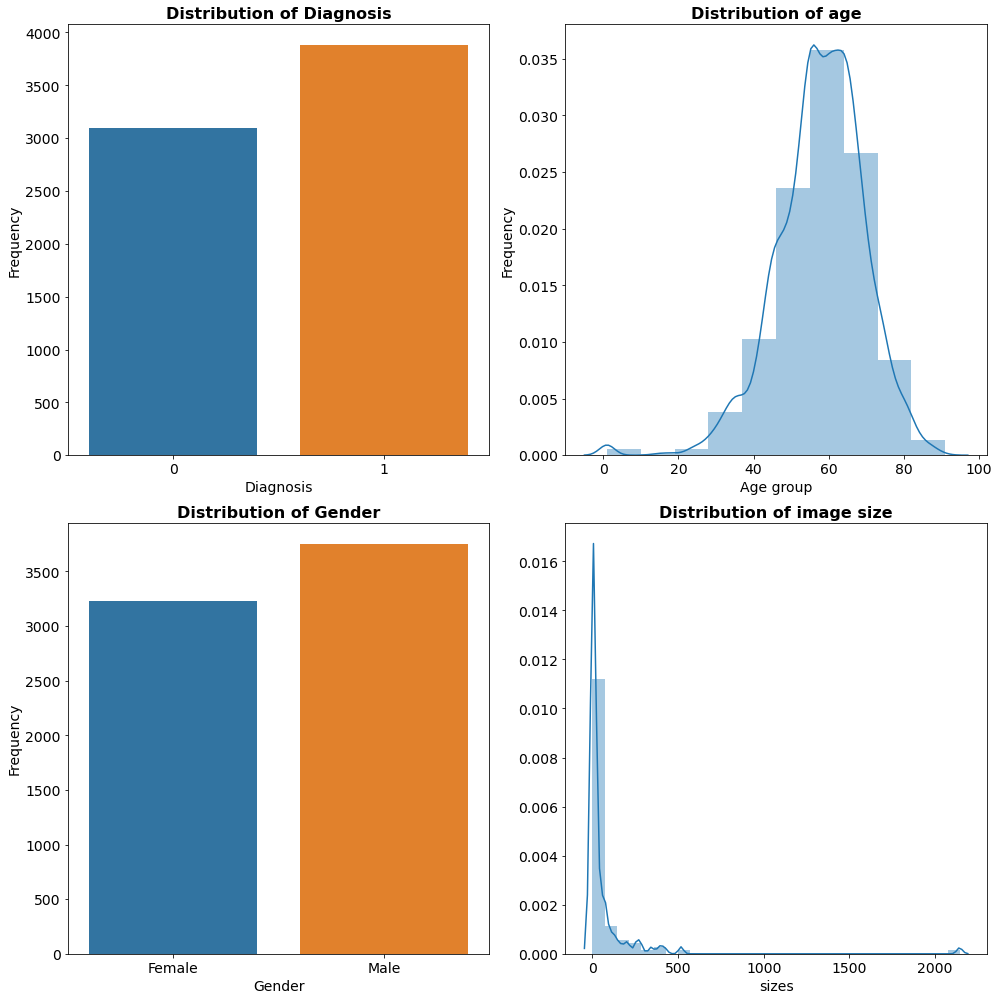

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 14))
ax = ax.ravel()
sns.barplot(x=df['abnormal'].value_counts(ascending=True).index,
            y=df['abnormal'].value_counts(ascending=True).values,
            ax=ax[0])
myfunc.subplot_data(ax, 0, 'Distribution of Diagnosis', 'Diagnosis', 'Frequency')

sns.distplot(df['Patient Age'].sort_values(),bins=10,ax=ax[1])
myfunc.subplot_data(ax, 1, 'Distribution of age', 'Age group', 'Frequency')

sns.countplot(x=df['Patient Sex'].sort_values(), ax=ax[2])
myfunc.subplot_data(ax, 2, 'Distribution of Gender', 'Gender', 'Frequency')

sns.distplot(df['img_size'].value_counts().sort_index(),bins=30,ax=ax[3])
myfunc.subplot_data(ax, 3, 'Distribution of image size', 'sizes', '')

plt.tight_layout();


**Save dataframe**

In [27]:
df.to_csv('../assets/data_v1.csv', index=False)

<div style="text-align: right">
<div class="right">
        <a href="./02_preprocessing.ipynb">>>> Next: Image Preprocessing</a>
    </div>
    </div>

[Go to top](#top)

---